In [8]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets
import nanonets_utils

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [9]:
voltages = np.random.uniform(-0.1,0.1, size=(300,9))

topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[6,0,0],[0,3,0],[0,6,0],[3,6,0],[6,3,0],[6,6,0]]
}

In [10]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [11]:
def run_kmc(voltages, topology_parameter, sim_dic):

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic, verbose=True)

    df              = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    I_target_values = np_network_cubic.I_target_values
    
    return df, pd.DataFrame(I_target_values).T

In [12]:
def return_parameters(jumps_per_batch, max_jumps):

    sim_dic1 ={
        'error_th'        : 0.05,
        'max_jumps'       : max_jumps,
        'eq_steps'        : 1000,
        'jumps_per_batch' : jumps_per_batch,
        'kmc_counting'    : False
    }

    sim_dic2 ={
        'error_th'        : 0.05,
        'max_jumps'       : max_jumps,
        'eq_steps'        : 1000,
        'jumps_per_batch' : jumps_per_batch,
        'kmc_counting'    : True
    }

    return sim_dic1, sim_dic2

In [13]:
sim_dic1, sim_dic2  = return_parameters(1, 200*1)
df1, I1 = run_kmc(voltages, topology_parameter, sim_dic1)

In [14]:
batch_sizes = [1,2,4,8,16,32,64,128,256,512,1024,2048]
dic_gamma   = {} 
dic_gamma_I = {}
dic_count   = {}
dic_count_I = {}
time_gamma  = []
time_count  = []

for j_per_batch in batch_sizes:

    sim_dic1, sim_dic2  = return_parameters(j_per_batch, 200*j_per_batch)

    # Gamma
    t1 = time.process_time()
    df1, I1 = run_kmc(voltages, topology_parameter, sim_dic1)
    t2 = time.process_time()

    dic_gamma[j_per_batch]      = df1
    dic_gamma_I[j_per_batch]    = I1
    time_gamma.append(t2-t1)

    # Count
    df2, I2 = run_kmc(voltages, topology_parameter, sim_dic2)
    t3 = time.process_time()

    dic_count[j_per_batch]      = df2
    dic_count_I[j_per_batch]    = I2
    time_count.append(t3-t2)

In [15]:
dic_gamma[j_per_batch]

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.079072,0.018715,-0.008881,-0.028179,-0.058129,0.074210,-0.087733,0.046048,0.090265,1000.0,143360.0,-46.692154,2.320660
1,-0.084559,0.053411,0.069903,-0.000355,-0.072342,0.080713,0.086896,-0.051594,0.018270,1000.0,102400.0,-552.016574,7.242713
2,0.003853,0.036740,0.024764,0.074327,-0.072037,-0.040346,0.098256,0.018774,-0.017424,1000.0,409600.0,-8.365175,0.454193
3,0.010088,0.023941,-0.023908,0.042319,0.024206,0.027091,0.005346,-0.094523,-0.024398,1000.0,102400.0,-95.056566,2.648724
4,0.029736,0.042213,0.053158,0.026442,0.099794,0.039326,0.023871,-0.056833,0.011859,1000.0,409600.0,-6.560202,0.569338
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-0.026427,-0.013047,-0.012722,-0.011243,0.070599,0.051033,-0.061496,0.096122,-0.036201,1000.0,112640.0,38.008693,1.898414
296,-0.008794,0.063974,0.010606,-0.068165,-0.012413,-0.075072,0.046799,-0.000477,-0.012685,1000.0,102400.0,-652.998057,5.802545
297,-0.071359,0.097597,0.043122,0.082663,0.009087,-0.091241,-0.090341,0.068223,0.048590,1000.0,102400.0,-1307.892170,11.708294
298,-0.098114,-0.080157,0.044659,-0.059713,0.044810,-0.017584,0.069812,-0.041851,0.024598,1000.0,102400.0,801.078957,6.148789


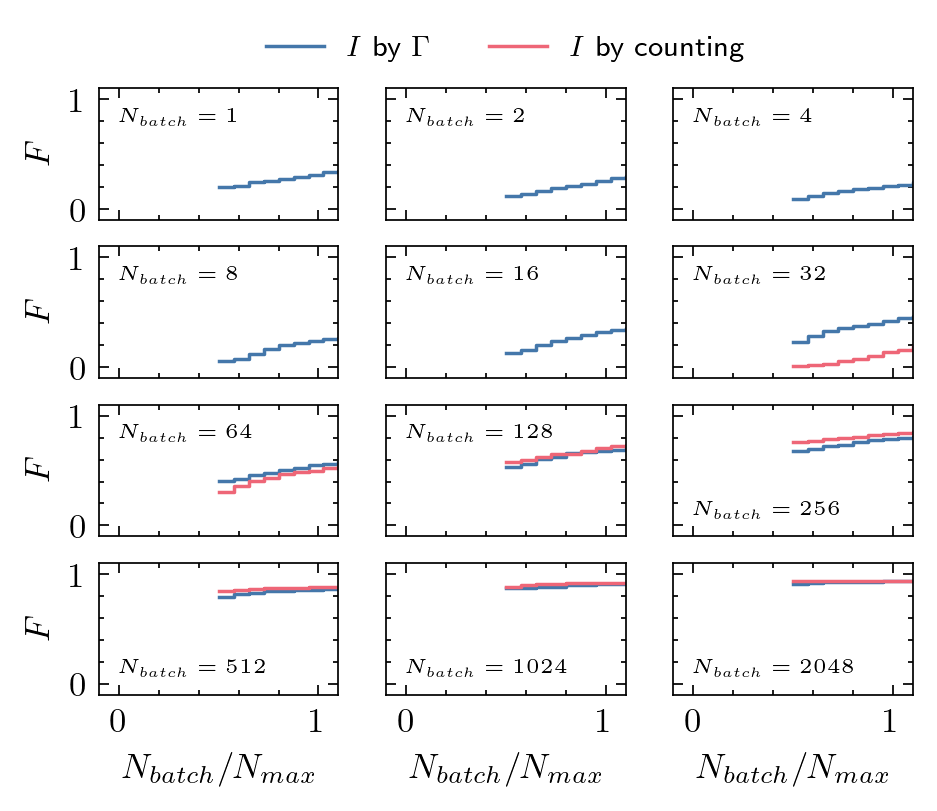

In [16]:
ncol = 3
nrow = 4

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250)
    fig.set_figheight(fig.get_figheight()*1.2)
    fig.set_figwidth(fig.get_figwidth()*1.2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        ax  = fig.add_subplot(nrow,ncol,i+1)
        ax  = sns.histplot(dic_gamma[j_per_batch][10]/(100*j_per_batch), label="$I$ by $\Gamma$", cumulative=True, bins=20, element='step', fill=False, stat='probability')
        ax  = sns.histplot(dic_count[j_per_batch][10]/(100*j_per_batch), label="$I$ by counting", cumulative=True, bins=20, element='step', fill=False, stat='probability')
        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(-0.1,1.1)
    
        if i % ncol != 0:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        else:
            ax.set_ylabel('$F$')
        
        if i >= (nrow-1)*ncol:
            ax.set_xlabel('$N_{batch}/N_{max}$')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels('')

        if (i == 0):
            ax.legend(loc='center',bbox_to_anchor=(1.7,1.3), fontsize='small', ncol=2)

        if i < 8:
            ax.text(x=0,y=0.8,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')
        else:
            ax.text(x=0,y=0.1,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')

    # ax.set_xlabel('KMC Steps')
    # ax.legend()

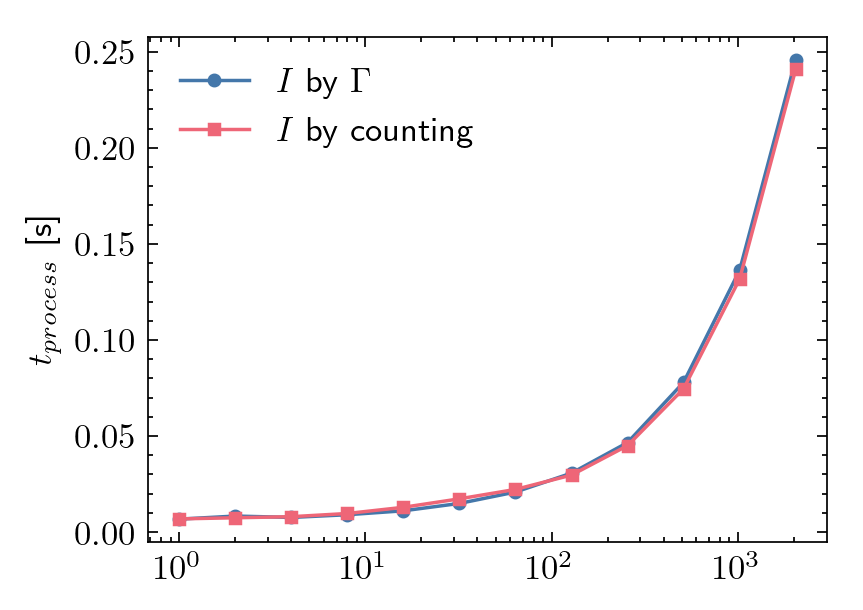

In [17]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250)
    ax  = fig.add_subplot()
    ax.plot(batch_sizes, np.array(time_gamma)/300, 'o-', label="$I$ by $\Gamma$", ms=3)
    ax.plot(batch_sizes, np.array(time_count)/300, 's-', label="$I$ by counting", ms=3)
    ax.set_ylabel('$t_{process}$ [s]')
    ax.legend()
    # ax.set_yscale('log') 
    ax.set_xscale('log')

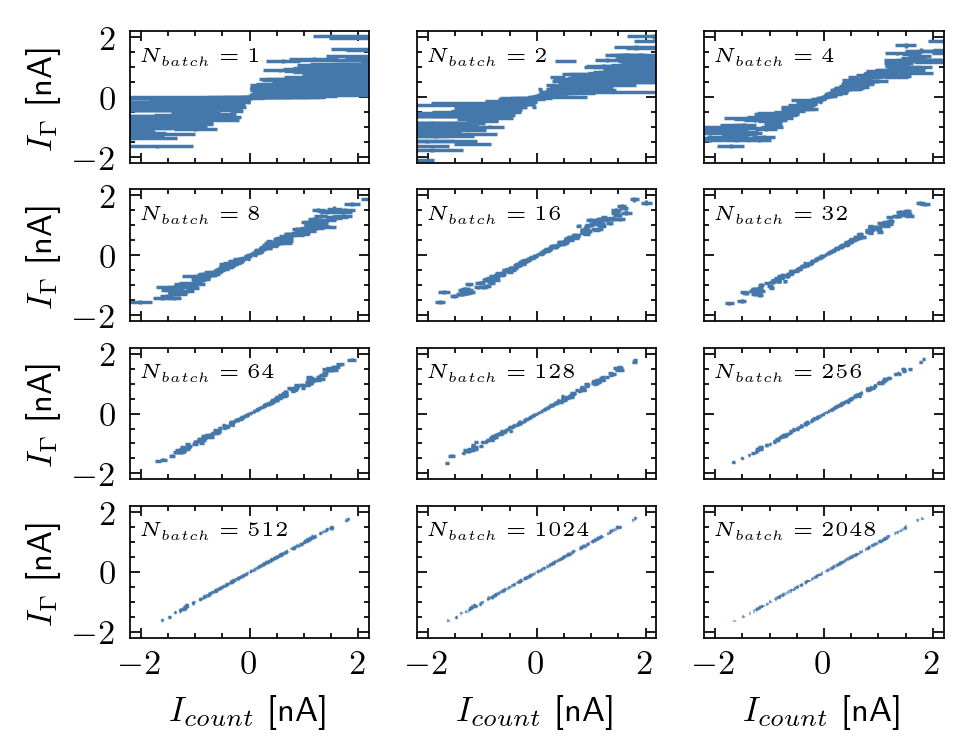

In [18]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250)
    fig.set_figheight(fig.get_figheight()*1.2)
    fig.set_figwidth(fig.get_figwidth()*1.2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        ax  = fig.add_subplot(nrow,ncol,i+1)
        ax.errorbar(x=dic_count[j_per_batch][11]/1000, y=dic_gamma[j_per_batch][11]/1000, xerr=dic_count[j_per_batch][12]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='')

        ax.set_xlim(-2.2,2.2)
        ax.set_ylim(-2.2,2.2)
    
        if i % ncol != 0:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        else:
            ax.set_ylabel('$I_{\Gamma}$ [nA]')
        
        if i >= (nrow-1)*ncol:
            ax.set_xlabel('$I_{count}$ [nA]')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels('')

        ax.text(x=-2,y=1.2,s='$N_{batch}' + f' = {j_per_batch}$', fontsize='xx-small')

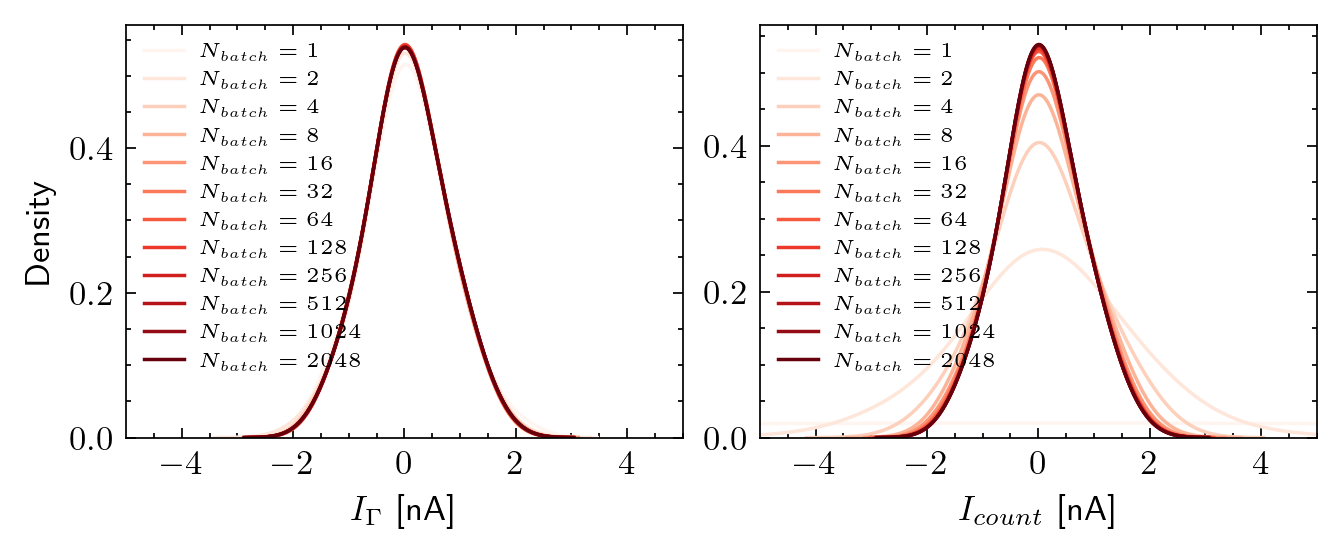

In [19]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=250, layout='constrained')
    fig.set_figheight(fig.get_figheight()*0.8)
    fig.set_figwidth(fig.get_figwidth()*1.5)

    ax  = fig.add_subplot(1,2,1)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        # ax.errorbar(x=np.arange(300), y=dic_gamma[j_per_batch][11]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='-')
        ax = sns.kdeplot(dic_gamma[j_per_batch][11]/1000, bw_adjust=2, color=cmap(i/(len(dic_gamma.keys())-1)), label='$N_{batch}'+f' = {j_per_batch}$')
        ax.set_xlabel('$I_{\Gamma}$ [nA]')
    
    ax.legend(fontsize='xx-small')
    ax.set_xlim(-5,5)

    ax  = fig.add_subplot(1,2,2)

    for i, j_per_batch in enumerate(dic_gamma.keys()):

        # ax.errorbar(x=np.arange(300), y=dic_gamma[j_per_batch][11]/1000, yerr=dic_gamma[j_per_batch][12]/1000, ls='-')
        ax = sns.kdeplot(dic_count[j_per_batch][11]/1000, bw_adjust=2, color=cmap(i/(len(dic_gamma.keys())-1)), label='$N_{batch}'+f' = {j_per_batch}$')
        ax.set_xlabel('$I_{count}$ [nA]')

    ax.set_xlim(-5,5)
    ax.legend(fontsize='xx-small')
    ax.set_ylabel('')

In [89]:
auto_corrs  = []
key         = 1 

for i in range(300):
    auto_corrs.append(autocorrelation(dic_gamma_I[key].iloc[:50,i].values,dic_gamma_I[key].iloc[:50,i].values,40))

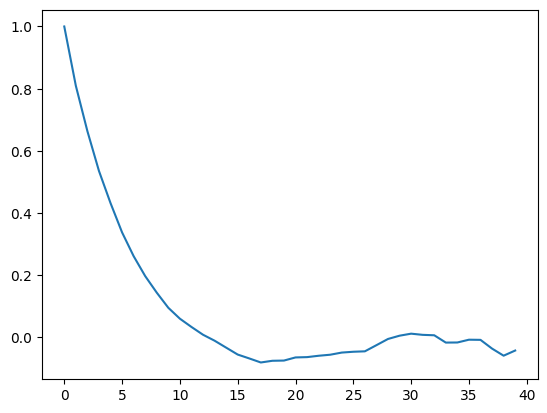

In [90]:
plt.plot(np.nanmean(auto_corrs,axis=0))

In [ ]:
plt.plot(autocorrelation(I1.iloc[:50,0].values,I1.iloc[:50,0].values,49))

In [ ]:
df_I1 = I1.iloc[:50,:]
df_I2 = I2.iloc[:50,:]

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax.plot(np.arange(50), df_I1.mean(axis=1), 's-', ms=2)
    ax.fill_between(np.arange(50), df_I1.mean(axis=1)-df_I1.std(axis=1)/np.sqrt(300),
                    df_I1.mean(axis=1)+df_I1.std(axis=1)/np.sqrt(300), alpha=0.5)

    ax.plot(np.arange(50), df_I2.mean(axis=1), 'o-', ms=2)
    ax.fill_between(np.arange(50), df_I2.mean(axis=1)-df_I2.std(axis=1)/np.sqrt(300),
                    df_I2.mean(axis=1)+df_I2.std(axis=1)/np.sqrt(300), alpha=0.5)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=300, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.2)
    fig.set_figheight(fig.get_figheight()*1.2)

    fig.suptitle(f'Max Steps allowed : {max_jumps}, Steps per batch : {jumps_per_batch}', fontsize='small')

    ax  = fig.add_subplot(2,1,1)
    ax.errorbar(x=df1[11], y=df2[11], xerr=df1[12], yerr=df2[12], marker='.', capsize=2, ls='', ms=1, elinewidth=1, capthick=1)
    ax.set_xlabel("$I$ by $\Gamma$")
    ax.set_ylabel("$I$ by counting")
    ax.set_xlim(-1500,1500)
    ax.set_ylim(-1500,1500)

    ax  = fig.add_subplot(2,1,2)
    ax  = sns.kdeplot(df1[10], label="$I$ by $\Gamma$")
    ax  = sns.kdeplot(df2[10], label="$I$ by counting")
    ax.set_xlim(0,100000)
    ax.set_xlabel('KMC Steps')
    ax.set_ylabel('')
    ax.legend()

    fig.savefig(f"count_vs_gamma_{jumps_per_batch}.png")

In [ ]:
voltages        = np.zeros(shape=(300,3))
voltages[:,0]   = np.linspace(0,0.1,300)

topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

In [ ]:
jumps_per_batch = 1000
max_jumps       = 100000

sim_dic1 ={
    'error_th'        : 0.05,
    'max_jumps'       : max_jumps,
    'eq_steps'        : 1000,
    'jumps_per_batch' : jumps_per_batch,
    'kmc_counting'    : False
}

sim_dic2 ={
    'error_th'        : 0.05,
    'max_jumps'       : max_jumps,
    'eq_steps'        : 1000,
    'jumps_per_batch' : jumps_per_batch,
    'kmc_counting'    : True
}

In [ ]:
t1 = time.process_time()
df1, I1 = run_kmc(voltages, topology_parameter, sim_dic1)
t2 = time.process_time()
print(t2-t1)

df2, I2 = run_kmc(voltages, topology_parameter, sim_dic2)
t3 = time.process_time()
print(t3-t2)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    ax.errorbar(df1[0]*1000, df1[5], np.abs(df1[6]), marker='o', label=f'Gamma-KMC',
                ms=2, capsize=2, markevery=10, errorevery=10, lw=0.5)
    ax.errorbar(df2[0]*1000, df2[5], np.abs(df2[6]), marker='s', label=f'Counting-KMC',
                ms=2, capsize=2, markevery=(5,10), errorevery=(5,10), lw=0.5)

    ax.set_xlabel('$U$ [mV]')
    ax.set_ylabel('$I$ [pA]')
    ax.legend(fontsize='small')

In [ ]:
dic             = {}
net_parameter   = [[2,1],[2,2],[3,2],[3,3]]
jumps_per_stat  = 50000

for i,net_params in enumerate(net_parameter):

    # Network Parameter
    topology_parameter = {
        "Nx"    : net_params[0],
        "Ny"    : net_params[1],
        "Nz"    : 1,
        "e_pos" : [[0,0,0],[net_params[0]-1,net_params[1]-1,0]]
    }

    sim_dic ={
        'error_th'        : 0.05,
        'max_jumps'       : 1000000,
        'eq_steps'        : 10000,
        'jumps_per_stat'  : jumps_per_stat}

    voltages        = np.zeros(shape=(600,3))
    voltages[:,0]   = np.linspace(0,0.1,600)

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic)

    df1      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    df1[7]   = np_network_cubic.return_potential_landscape()[:,topology_parameter['Nx']*topology_parameter['Ny']+1]
    df1      = df1.sort_values(by=0)
    dic[i]   = df1

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for key, df in dic.items():

        ax.plot(df[7]*1000, df[5], '.', label=f'$N_x = {net_parameter[key][0]}$, $N_y = {net_parameter[key][1]}$', ms=2)

    ax.set_xlabel('NP Potential')
    ax.set_ylabel('Current')
    ax.set_ylim(0,5000)
    ax.set_xlim(0,30)
    ax.legend(fontsize='small')

    fig.savefig(f'I_phi_{jumps_per_stat}.png')

In [ ]:
ele_charge  = 0.160217662
c_inv       = np_network_cubic.inv_capacitance_matrix

def free_energy1(pot):
    return -ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def free_energy2(pot):
    return ele_charge*pot + (ele_charge*ele_charge/2)*c_inv[3,3]

def tunnel_rate(df):

    R           = 25e-12
    gamma       = np.zeros(len(df))
    gamma[df<0] = -df[df<0]/(ele_charge*ele_charge*R)

    return gamma

In [ ]:
# def pot_current_dep(voltages, n_jumps=10000, eq_steps=10000):

#     pot_landscape   = np.zeros(n_jumps)
#     time_vals       = np.zeros(n_jumps)
#     pos_jumps       = np.zeros(n_jumps)
#     neg_jumps       = np.zeros(n_jumps)
#     rate_diffs      = np.zeros(n_jumps)

#     np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)

#     # Based on current voltages get charges and potentials
#     np_network_cubic.init_charge_vector(voltages)
#     np_network_cubic.init_potential_vector(voltages)
#     np_network_cubic.init_const_capacitance_values()
#     np_network_cubic.np_target_electrode_electrostatic_properties(1)

#     # Return Model Arguments
#     inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
#     charge_vector                                                                           = np_network_cubic.return_charge_vector()
#     potential_vector                                                                        = np_network_cubic.return_potential_vector()
#     const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
#     N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
#     adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
#     temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
#     resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
#     idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

#     # Pass all model arguments into Numba optimized Class
#     model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
#                             temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
#                             co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
#     model.calc_potentials()

#     for i in range(eq_steps):
        
#         random_number1  = np.random.rand()
#         random_number2  = np.random.rand()
#         model.calc_tunnel_rates_zero_T()
#         model.select_event(random_number1, random_number2)

#     model.time = 0.0

#     rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
#     rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

#     for i in range(n_jumps):

#         t1 = model.time
        
#         pot_landscape[i]= model.potential_vector[5]
        
#         random_number1  = np.random.rand()
#         random_number2  = np.random.rand()
#         model.calc_tunnel_rates_zero_T()
#         rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
#         model.select_event(random_number1, random_number2)

#         np1 = model.adv_index_rows[model.jump]
#         np2 = model.adv_index_cols[model.jump]

#         # If jump from target electrode
#         if (np1 == 1):
#             neg_jumps[i] = 1
            
#         # If jump towards target electrode
#         if (np2 == 1):
#             pos_jumps[i] = 1
        
#         t2 = model.time

#         time_vals[i] = t2-t1
    
#     return pd.DataFrame((np.array(pot_landscape),np.sum(np.array(time_vals)),pos_jumps-neg_jumps, np.array(rate_diffs))).T

In [ ]:
def pot_current_dep(voltages, topology_parameter, n_jumps=10000, eq_steps=10000):

    pot_landscape   = np.zeros(n_jumps)
    time_vals       = np.zeros(n_jumps)
    pos_jumps       = np.zeros(n_jumps)
    neg_jumps       = np.zeros(n_jumps)
    rate_diffs      = np.zeros(n_jumps)

    np_network_cubic    = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)

    # Based on current voltages get charges and potentials
    np_network_cubic.init_charge_vector(voltages)
    np_network_cubic.init_potential_vector(voltages)
    np_network_cubic.init_const_capacitance_values()
    np_network_cubic.np_target_electrode_electrostatic_properties(1)

    # Return Model Arguments
    inv_capacitance_matrix                                                                  = np_network_cubic.return_inv_capacitance_matrix()
    charge_vector                                                                           = np_network_cubic.return_charge_vector()
    potential_vector                                                                        = np_network_cubic.return_potential_vector()
    const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2    = np_network_cubic.return_const_capacitance_values()
    N_electrodes, N_particles                                                               = np_network_cubic.return_particle_electrode_count()
    adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2, co_adv_index3             = np_network_cubic.return_advanced_indices()
    temperatures, temperatures_co                                                           = np_network_cubic.return_const_temperatures(T=0.0)
    resistances, resistances_co1, resistances_co2                                           = np_network_cubic.return_random_resistances(R=np_network_cubic.res_info['mean_R'], Rstd=np_network_cubic.res_info['std_R'])
    idx_np_target, C_np_self, C_np_target                                                   = np_network_cubic.return_output_electrostatics()

    # Pass all model arguments into Numba optimized Class
    model = nanonets.model_class(charge_vector, potential_vector, inv_capacitance_matrix, const_capacitance_values, const_capacitance_values_co1, const_capacitance_values_co2,
                            temperatures, temperatures_co, resistances, resistances_co1, resistances_co2, adv_index_rows, adv_index_cols, co_adv_index1, co_adv_index2,
                            co_adv_index3, N_electrodes, N_particles, C_np_target, C_np_self)
    
    model.calc_potentials()

    for i in range(eq_steps):
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        model.select_event(random_number1, random_number2)

    model.time = 0.0

    rate_index1 = np.where(np_network_cubic.adv_index_cols == 1)[0][0]
    rate_index2 = np.where(np_network_cubic.adv_index_rows == 1)[0][0]

    for i in range(n_jumps):

        t1 = model.time
        
        pot_landscape[i]= model.potential_vector[topology_parameter['Nx']*topology_parameter['Ny']+1]
        
        random_number1  = np.random.rand()
        random_number2  = np.random.rand()
        model.calc_tunnel_rates_zero_T()
        rate_diffs[i] = model.tunnel_rates[rate_index1] - model.tunnel_rates[rate_index2]
        model.select_event(random_number1, random_number2)

        np1 = model.adv_index_rows[model.jump]
        np2 = model.adv_index_cols[model.jump]

        # If jump from target electrode
        if (np1 == 1):
            neg_jumps[i] = 1
            
        # If jump towards target electrode
        if (np2 == 1):
            pos_jumps[i] = 1
        
        t2 = model.time

        time_vals[i] = t2-t1
    
    return [np.mean(np.array(pot_landscape)),np.sum(np.array(time_vals)),np.sum(pos_jumps-neg_jumps), np.sum(np.array(rate_diffs)*time_vals)*(10**(-6))/np.sum(time_vals)]

In [ ]:
dic1            = {}
dic2            = {}
net_parameter   = [[2,1],[2,2],[3,2],[3,3]]
jumps_per_stat  = 1000

for i,net_params in enumerate(net_parameter):

    # Network Parameter
    topology_parameter = {
        "Nx"    : net_params[0],
        "Ny"    : net_params[1],
        "Nz"    : 1,
        "e_pos" : [[0,0,0],[net_params[0]-1,net_params[1]-1,0]]
    }

    sim_dic ={
        'error_th'        : 0.05,
        'max_jumps'       : 1000000,
        'eq_steps'        : 10000,
        'jumps_per_stat'  : jumps_per_stat}

    voltages        = np.zeros(shape=(600,3))
    voltages[:,0]   = np.linspace(0,0.1,600)

    np_network_cubic = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
    np_network_cubic.run_const_voltages(voltages=voltages, target_electrode=1, save_th=0.1, output_potential=False, sim_dic=sim_dic)

    df1      = pd.DataFrame(np.hstack((voltages,np_network_cubic.return_output_values())))
    df1[7]   = np_network_cubic.return_potential_landscape()[:,topology_parameter['Nx']*topology_parameter['Ny']+1]
    df1      = df1.sort_values(by=0)
    dic1[i]  = df1

    ##########################################################

    vals = []

    for V in voltages[:,0]:

        v_array = np.array([V,0.0,0.0])
        vals.append(pot_current_dep(v_array, topology_parameter, jumps_per_stat))

    df1 = pd.DataFrame(vals)
    dic2[i] = df1

In [ ]:
dic1[i]*ele_charge

In [ ]:
with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*1.5)

    for i in dic.keys():

        ax  = fig.add_subplot(2,2,i+1)
        ax.plot(np.linspace(0,0.1,600)*1000, dic2[i][3].values*ele_charge, 'o', label='$I = e \cdot (\Gamma_+ - \Gamma_-)$', ms=1)
        ax.plot(np.linspace(0,0.1,600)*1000, dic1[i][5]*ele_charge, 'o', label='$I$ based on counting', ms=1)
        
        if i == 0:
            ax.legend(loc='center', bbox_to_anchor=(1,1.2), ncol=2)
        if i == 0 or i == 2:
            ax.set_ylabel('I [pA]')
        if i == 2 or i == 3:
            ax.set_xlabel('U [mV]')
        
        ax.set_ylim(0,800)
        ax.set_xlim(0,100)

    fig.savefig("I_comparsion.png")

In [ ]:
n_jumps     = 10000
vals        = []

for V in np.linspace(-0.1,0.1,600):

    voltages    = np.array([V,0.0,0.0])
    vals.append(pot_current_dep(voltages, topology_parameter, jumps_per_stat))
    
df = pd.DataFrame(vals)
df

In [ ]:
plt.plot(np.cumsum(df[1]), df[3]*10**(-6))

In [ ]:
free_e = free_energy(df[0])

with plt.style.context(["science","bright"]):
    
    plt.figure(dpi=200)
    plt.plot(df[0], '.-')
    plt.plot(free_e)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylim(0, 0.1)
    plt.ylabel('Potential')
    plt.xlabel('Jumps')

In [ ]:
gamma = tunnel_rate(free_e)

with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(gamma)
    plt.vlines(np.arange(len(df[1]))[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.xlim(0,100)
    plt.ylabel('Gamma')
    plt.xlabel('Jumps')

In [ ]:
with plt.style.context(["science","bright"]):
    plt.figure(dpi=200)
    plt.plot(np.cumsum(df[1]),df[0], '.-')
    plt.vlines(np.cumsum(df[1]).values[df[2].values == 1], ymin=0, ymax=0.15, color='black', lw=0.5)
    plt.ylim(0, 0.1)
    plt.xlim(0,2e-9)
    plt.ylabel('Potential')
    plt.xlabel('Time')

In [ ]:
I = tunnel_rate(free_energy1(df[0])) - tunnel_rate(free_energy2(df[0]))
plt.plot(I)
plt.xlim(0,100)

In [ ]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot()
    ax.plot(np.cumsum(df[1]), np.cumsum(df[2]), '.-')
    ax.set_xlim(0,1e-9)
    ax.set_ylim(0,10)

    ax2 = ax.twinx()
    ax2.plot(np.cumsum(df[1]), df[0], '.-', c='red')
    ax2.set_xlim(0,1e-9)

In [ ]:
vals_per_bin    = 2
df[3]           = np.repeat(np.arange(1,n_jumps/vals_per_bin+1),vals_per_bin)
df_bins         = df[[0,3]].groupby(by=3).mean()
df_bins[1]      = df[[2,3]].groupby(by=3).sum()[2]/df[[1,3]].groupby(by=3).sum()[1]

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200,layout='constrained')
    ax  = fig.add_subplot(3,1,1)
    ax.plot(df_bins[0], df_bins[1], '.')

    ax  = fig.add_subplot(3,1,2)
    ax.plot(df_bins[0], '.')

    ax  = fig.add_subplot(3,1,3)
    ax.plot(df_bins[1], '.')